(1247, 6)
[[0.5156102175959969, 0.4645270270262423, 0.5194681861338661, 0.08431203546519844], [0.4966887417209145, 0.45608108108031065, 0.5080721747378764, 0.04991152117204296], [0.5042573320709475, 0.45608108108031065, 0.5137701804358713, 0.04383591988260342], [0.5364238410585876, 0.47804054053973305, 0.5403608736931806, 0.09229521155418953], [0.5383159886460959, 0.47804054053973305, 0.5308641975298559, 0.07379510038958709], [0.5402081362336041, 0.48310810810729204, 0.5479582146238405, 0.11670796641001277], [0.5742667928087526, 0.5202702702693914, 0.5821462488118098, 0.1855981338968496], [0.585619678333802, 0.5304054054045094, 0.5916429249751346, 0.11715737454843514], [0.5875118259213102, 0.5253378378369504, 0.5935422602077995, 0.04837170108943167], [0.5799432355712772, 0.5253378378369504, 0.5916429249751346, 0.04407893601796677]] -> [0.5854341736683746]
전체 데이터의 크기 : 1237 1237
훈련 데이터의 크기 : (865, 10, 4) (865, 1)
테스트 데이터의 크기 : (372, 10, 4) (372, 1)
Model: "sequential_6"
________________

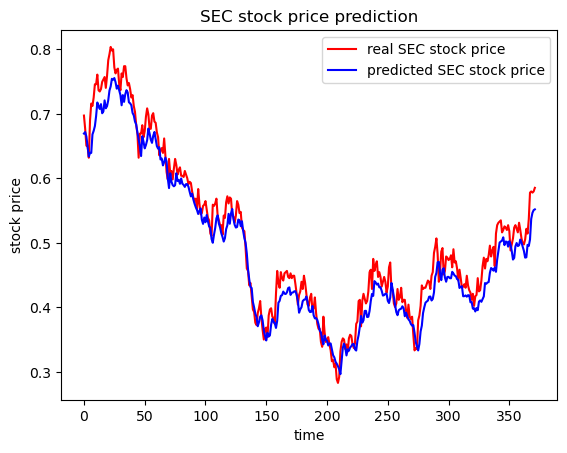

내일 SEC 주가 : [64872.05290829] KRW
내일 SEC 주가는 떨어집니다. 예상 종가: [64872.05290829] 원


In [10]:
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout


df = fdr.DataReader('005930', '2018-05-04', '2023-05-25') #삼전
print(df.shape)

def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

dfx = df[['Open','High','Low','Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]
dfx = dfx[['Open','High','Low','Volume']]
dfx.describe() #모든 값이 0과 1 사이인 것 확인

X = dfx.values.tolist()
y = dfy.values.tolist()

window_size = 10
data_X = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i : i + window_size]
    _y = y[i + window_size]
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

print('전체 데이터의 크기 :', len(data_X), len(data_y))
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])
test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])
print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(10, 4)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, epochs=70, batch_size=1)
pred_y =model.predict(test_X)

pred_y = model.predict(test_X)
plt.figure()
plt.plot(test_y, color='red', label='real SEC stock price')
plt.plot(pred_y, color='blue', label='predicted SEC stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()
print("내일 SEC 주가 :", df.Close[-1] * pred_y[-1] / dfy.Close[-1], 'KRW')

# Predict the next closing price
pred_next_close_price = df.Close[-1] * pred_y[-1] / dfy.Close[-1]

# Compare the last actual closing price and the predicted next closing price
if pred_next_close_price > df.Close[-1]:
    print("내일 SEC 주가는 오릅니다. 예상 종가:", pred_next_close_price, '원')
else:
    print("내일 SEC 주가는 떨어집니다. 예상 종가:", pred_next_close_price, '원')
